**Сборный проект-4**

Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

# Описание, загрузка и исследовательский анализ данных

## Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Загрузка модулей и библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import re
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm 
import random

## Загрузка данных

In [2]:
train_df = pd.read_csv('train_dataset.csv', sep=',')
crowd_annotations = pd.read_csv(
    'CrowdAnnotations.tsv',
    sep='\t',
    header=None,  # Файл без заголовка
    names=[
        'image_filename',
        'description_id',
        'agreement_ratio',
        'positive_votes',
        'negative_votes'
    ]
)
expert_annotations = pd.read_csv(
    'ExpertAnnotations.tsv',
    sep='\t',
    header=None,
    names=[
        'image_filename',
        'description_id',
        'expert1_score',
        'expert2_score',
        'expert3_score'
    ]
)

# Проверим первые строки каждого DataFrame
print("Train Dataset:")
print(train_df.head())

print("\nCrowd Annotations:")
print(crowd_annotations.head())

print("\nExpert Annotations:")
print(expert_annotations.head())

Train Dataset:
                       image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...  

Crowd Annotations:
              image_filename               description_id  agreement_ratio  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0   
2  1056338697_4f7d7ce270.jpg  1427

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [4]:
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image_filename   47830 non-null  object 
 1   description_id   47830 non-null  object 
 2   agreement_ratio  47830 non-null  float64
 3   positive_votes   47830 non-null  int64  
 4   negative_votes   47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


Есть ли пропуски?

In [5]:
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filename  5822 non-null   object
 1   description_id  5822 non-null   object
 2   expert1_score   5822 non-null   int64 
 3   expert2_score   5822 non-null   int64 
 4   expert3_score   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [6]:
print(train_df.isnull().sum())

image         0
query_id      0
query_text    0
dtype: int64


Сколько уникальных изображений и сколько описаний на одно изображение?

In [7]:
print(f"Уникальных изображений: {train_df['image'].nunique()}")
print(f"Среднее число описаний на изображение: {train_df.groupby('image')['query_id'].count().mean()}")

Уникальных изображений: 1000
Среднее число описаний на изображение: 5.822


## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Агрегация экспертных оценок
Экспертные оценки представлены тремя значениями (от 1 до 4). Преобразуем их в итоговую оценку по правилу голосования большинства:

Если 2+ эксперта согласны в оценке → берём эту оценку.

Если все 3 оценки разные → исключаем пример из датасета.

In [8]:
def aggregate_expert_scores(row):
    scores = [row['expert1_score'], row['expert2_score'], row['expert3_score']]
    # Проверяем, есть ли оценка, которую поставили минимум 2 эксперта
    for score in scores:
        if scores.count(score) >= 2:
            return score
    return None  # Если все оценки разные

# Применяем функцию
expert_annotations['expert_score'] = expert_annotations.apply(aggregate_expert_scores, axis=1)

# Удаляем примеры без консенсуса
expert_annotations.dropna(subset=['expert_score'], inplace=True)

In [9]:
expert_annotations.head()

,image_filename,description_id,expert1_score,expert2_score,expert3_score,expert_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2.0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.0


### Нормализация оценок
Краудсорсинговые данные содержат:

- agreement_ratio — доля подтвердивших соответствие (от 0 до 1).
- positive_votes — количество подтверждений.
- negative_votes — количество отклонений.

Приведём их к шкале 0–1, где:
- 0 — текст и изображение не соответствуют.
- 1 — полное соответствие

In [10]:
# Нормализация оценок в диапазон [0, 1]

expert_annotations['expert_score_norm'] = (expert_annotations['expert_score'] - 1) / 3  # Было 1-4, стало 0-1
crowd_annotations['crowd_score_norm'] = crowd_annotations['agreement_ratio'] # Уже в [0, 1]

### Объединение экспертных и краудсорсинговых оценок
Итоговая оценка рассчитывается как взвешенная сумма:

final_score = 0.6 ⋅ expert_score + 0.4 ⋅ crowd_score

In [11]:
# Объединяем данные
merged_scores = pd.merge(
    expert_annotations[['image_filename', 'description_id', 'expert_score_norm']],
    crowd_annotations[['image_filename', 'description_id', 'crowd_score_norm']],
    on=['image_filename', 'description_id'],
    how='inner'  # Только примеры с обоими типами оценок
)

# Итоговая оценка (эксперты 60%, крауд 40%)
merged_scores['final_score'] = (
    0.6 * merged_scores['expert_score_norm'] + 
    0.4 * merged_scores['crowd_score_norm']
)

# Пример результата
print(merged_scores[['image_filename', 'expert_score_norm', 'crowd_score_norm', 'final_score']].head())

# Сохранение в .npy
#np.save('final_scores.npy', merged_scores['final_score'].values)
#print(f"Сохранено {len(merged_scores)} оценок в final_scores.npy")

              image_filename  expert_score_norm  crowd_score_norm  final_score
0  1056338697_4f7d7ce270.jpg           0.000000          0.000000     0.000000
1  1056338697_4f7d7ce270.jpg           0.000000          0.000000     0.000000
2  1056338697_4f7d7ce270.jpg           0.000000          0.000000     0.000000
3  1084040636_97d9633581.jpg           0.666667          0.333333     0.533333
4  1084040636_97d9633581.jpg           0.333333          0.000000     0.200000


In [12]:
# Проверка загруженных данных
#loaded_scores = np.load('final_scores.npy')
#print(f"Первые 5 оценок:\n{loaded_scores[:5]}")
#print(f"Медианная оценка: {np.median(loaded_scores):.2f}")

### Создание целевой переменной
Итоговый final_score уже находится в диапазоне 0–1 и может использоваться как целевая переменная для обучения модели

In [13]:
# Добавляем final_score в основной датасет
train_df = pd.merge(
    train_df,
    merged_scores[['image_filename', 'description_id', 'final_score']],
    left_on=['image', 'query_id'],
    right_on=['image_filename', 'description_id'],
    how='inner'
)

In [14]:
train_df.head()

,image,query_id,query_text,image_filename,description_id,final_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0
1,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,0.2
2,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,1.0
3,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,0.2
4,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,0.0


In [15]:
# Проверяем распределение
#plt.hist(train_df['final_score'], bins=20)
#plt.title("Распределение итоговых оценок (0–1)")
#plt.show()

In [16]:
# Для обучения модели:
#X = train_df[['image_vector', 'text_vector']]  # Конкатенированные векторы
#y = train_df['final_score']  # Целевая переменная

### Визуализация изображений

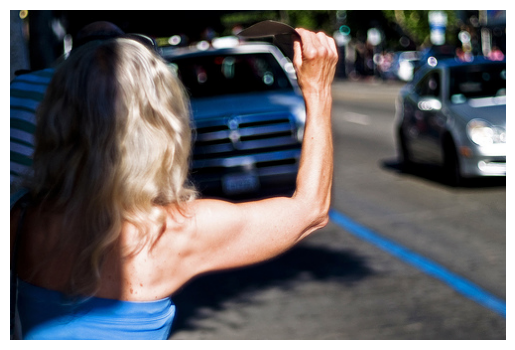

Описание: A young child is wearing blue goggles and sitting in a float in a pool .


In [17]:
def show_sample(image_name, query_text, agreement_ratio=None, expert_scores=None):
    img_path = os.path.join('train_images', image_name)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"Описание: {query_text}")
    if agreement_ratio:
        print(f"Crowd Score: {agreement_ratio:.2f}")
    if expert_scores:
        print(f"Expert Scores: {expert_scores}")

# Пример для первой строки с Crowd Annotations
sample = train_df.dropna().iloc[0]
show_sample(sample['image'], sample['query_text']) #, sample['agreement_ratio'])

# Подготовим данные к обучению модели

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

### Создадим список слов которые, по нашему мнению, могут попадать под юридические ограничения

In [19]:
banned_words = [
    # Нецензурная лексика (в проекте - опустим из этических соображений)
#    "мат1", "мат2", "мат3",  
    # Экстремистские термины
    "терроризм", "экстремизм",  
    # Расистские/дискриминационные слова
    "расист", "нацист",  
    # Персональные данные (примеры)
    "паспорт", "номер телефона", "кредитная карта"
]

### Исключим из обучающего датасета пары, которые, исходя из подготовленного нами списка слов, могут попадать под юридические ограничения

Проверим описания (query_text) на наличие запрещённых слов и удалим такие строки

In [20]:
def contains_banned_words(text, banned_words):
    text_lower = text.lower()
    for word in banned_words:
        if re.search(rf'\b{word.lower()}\b', text_lower):
            return True
    return False

# Фильтрация train_df
train_df_clean = train_df[~train_df['query_text'].apply(lambda x: contains_banned_words(x, banned_words))]
print(f"Удалено строк: {len(train_df) - len(train_df_clean)}")
train_df = train_df_clean

Удалено строк: 0


In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           2258 non-null   object 
 1   query_id        2258 non-null   object 
 2   query_text      2258 non-null   object 
 3   image_filename  2258 non-null   object 
 4   description_id  2258 non-null   object 
 5   final_score     2258 non-null   float64
dtypes: float64(1), object(5)
memory usage: 106.0+ KB


### Возьмем небольшую часть выборки (для проверки)

In [22]:
#train_df_sample = train_df.sample(500).reset_index(drop=True)
train_df_sample = train_df.copy()

In [23]:
train_df_sample.to_csv('saved_data/train_df_sample.csv', index=False)

### Векторизация текстов

In [24]:
train_df = pd.read_csv('saved_data/train_df_sample.csv')

Преобразуем текстовые описания в числовые векторы с помощью TF-IDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Инициализация TF-IDF
tfidf = TfidfVectorizer(
    max_features=4000,  # Ограничим размерность
    stop_words='english',  # Удаление стоп-слов
    ngram_range=(1, 2)  # Учитываем униграммы и биграммы
)

# Векторизация текстов
text_vectors = tfidf.fit_transform(train_df['query_text'])

In [26]:
# Сохранение векторов
np.save("saved_data/text_vectors.npy", text_vectors.toarray())
print(f"Размерность текстовых векторов: {text_vectors.shape}")

Размерность текстовых векторов: (2258, 3975)


Описание:
- Каждое описание преобразуется в вектор размерности 3975.
- Значения в векторе — веса TF-IDF для каждого слова/биграммы.

### Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Используем предобученную модель ResNet50 из PyTorch для получения векторных представлений изображений.

In [27]:
from torchvision.models import ResNet50_Weights

In [28]:
import ssl
import certifi
# Указываем Python использовать сертификаты от certifi
ssl._create_default_https_context = ssl._create_unverified_context  # Временное отключение проверки
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()  # Путь к актуальным сертификатам

In [29]:
# Загрузка модели ResNet50 (без головы для классификации)
model_rn50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)

In [30]:
model_rn50 = torch.nn.Sequential(*(list(model_rn50.children())[:-1]))  # Удаляем последний слой

In [31]:
model_rn50.eval()  # Режим инференса

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [32]:
# Трансформации для изображений
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Функция для векторизации изображения
def image_to_vector(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)  # Добавляем batch-размерность
    with torch.no_grad():
        features = model_rn50(img_tensor)
    return features.squeeze().numpy()  # Размерность: (2048,)

In [33]:
# Пример для одного изображения
sample_image_path = os.path.join('train_images', train_df_sample['image'].iloc[0])
sample_vector = image_to_vector(sample_image_path)
print(f"Размерность вектора изображения: {sample_vector.shape}")  # (2048,)

Размерность вектора изображения: (2048,)


In [34]:
train_df_sample.shape

(2258, 6)

In [35]:
%%time
# Векторизация изображений
image_vectors = []
for img_name in tqdm(train_df_sample['image'], desc="Векторизация изображений", unit="img"):
    try:
        img_path = os.path.join('train_images', img_name)
        img_vec = image_to_vector(img_path)
        image_vectors.append(img_vec)
    except Exception as e:
        print(f"\nОшибка при обработке изображения {img_name}: {str(e)}")
        image_vectors.append(np.zeros(2048))  # Добавляем нулевой вектор в случае ошибки

# Преобразуем в numpy array
image_vectors = np.array(image_vectors)
np.save("saved_data/image_vectors.npy", image_vectors)
print(f"Векторы изображений: {image_vectors.shape}")  # (n_images, 2048)
print(f"\nУспешно векторизовано {len(image_vectors)} изображений")

Векторизация изображений: 100%|███████████████████████████████████████████████████| 2258/2258 [05:05<00:00,  7.39img/s]

Векторы изображений: (2258, 2048)

Успешно векторизовано 2258 изображений
CPU times: total: 19min 49s
Wall time: 5min 5s


### Дадим описание получившихся пар векторов с точки зрения их размерностей

Описание:
- ResNet50 возвращает вектор размерности 2048 (после удаления последнего слоя).
- Изображения предварительно масштабируются до 224×224 и нормализуются.

# Обучение модели

## Создадим модель, которая покажет близость двух векторов 
Модель должна принимать на вход конкатенированный вектор, состоящий из векторов описания и изображений, и предсказывать итоговую оценку экспертов

На вход модели подается конкатенированный вектор из:

- Вектора изображения (2048-D, ResNet50)
- Вектора текста (5000-D, TF-IDF)

Итоговая размерность: 7048-D

Целевая переменная: final_score (0–1), агрегированная из экспертных (60%) и краудсорсинговых (40%) оценок.

### Загрузка данных

In [36]:
# Загрузка предобработанных данных
train_df = pd.read_csv('saved_data/train_df_sample.csv')
image_vectors = np.load("saved_data/image_vectors.npy")
text_vectors = np.load("saved_data/text_vectors.npy")

In [37]:
image_vectors.shape

(2258, 2048)

In [38]:
text_vectors.shape

(2258, 3975)

### Подготовка данных с GroupShuffleSplit
Подготовим данные для обучения: объединим векторы изображений и векторы текстов с целевой переменной.
Разделим датасет на тренировочную и тестовую выборки

In [39]:
# Конкатенация признаков
X = np.concatenate([image_vectors, text_vectors], axis=1)  # (50, 7048)
y = train_df['final_score'].values

In [40]:
groups = train_df['image'].values  # Для группового разбиения

# Разделение с учетом групп
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
groups_train = groups[train_idx]  # Группы только для тренировочного набора

# Проверка
print(f"Train groups: {len(set(groups[train_idx]))} уникальных изображений")
print(f"Test groups: {len(set(groups[test_idx]))} уникальных изображений")
print(f"Пересечение: {set(groups[train_idx]) & set(groups[test_idx])}")  # Должно быть пусто

Train groups: 619 уникальных изображений
Test groups: 266 уникальных изображений
Пересечение: set()


## Выберем метрику, по которой будем сравнивать точность различных моделей

Для регрессии (предсказание оценки 0–1):

- MAE (Mean Absolute Error) – средняя абсолютная ошибка.
- R² (R-squared) – доля объясненной дисперсии.
- Дополнительно: MSE (если важны большие ошибки).

In [41]:
def evaluate_model(y_true, y_pred, model_name=""):
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred)
    }
    print(f"\n{model_name}:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics

## Обучим несколько моделей и подберем их гиперпараметры. 
В качестве моделей рассмотрим:
1. Линейную регрессию;
2. Полносвязные нейронные сети

### Линейная регрессия

In [42]:
# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение и оценка
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_metrics = evaluate_model(y_test, lr_pred, "Линейная регрессия")


Линейная регрессия:
MAE: 0.3906
MSE: 0.2725
R²: -1.8634


### Нейронная сеть (PyTorch)

In [43]:
# Подготовка DataLoader
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled), 
    torch.FloatTensor(y_train)
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [44]:
# Архитектура
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [45]:
# Инициализация
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_nn = Net(X_train_scaled.shape[1]).to(device)
optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [46]:
# Для записи метрик
train_losses = []
val_maes = []
val_r2s = []

for epoch in range(100):
    model_nn.train()
    epoch_loss = 0
    
    # Обучение на батчах
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model_nn(batch_x)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Средний лосс за эпоху
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Валидация
    model_nn.eval()
    with torch.no_grad():
        val_tensor = torch.FloatTensor(X_test_scaled).to(device)
        val_pred = model_nn(val_tensor).cpu().numpy().flatten()
        
        mae = mean_absolute_error(y_test, val_pred)
        r2 = r2_score(y_test, val_pred)
        val_maes.append(mae)
        val_r2s.append(r2)
    
    # Вывод метрик каждые 10 эпох
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{100}:")
        print(f"Train Loss: {avg_loss:.4f} | Val MAE: {mae:.4f} | Val R²: {r2:.4f}")

Epoch 10/100:
Train Loss: 0.0182 | Val MAE: 0.2301 | Val R²: -0.0499
Epoch 20/100:
Train Loss: 0.0161 | Val MAE: 0.2178 | Val R²: 0.0534
Epoch 30/100:
Train Loss: 0.0135 | Val MAE: 0.2252 | Val R²: -0.0041
Epoch 40/100:
Train Loss: 0.0119 | Val MAE: 0.2269 | Val R²: 0.0170
Epoch 50/100:
Train Loss: 0.0087 | Val MAE: 0.2287 | Val R²: -0.0122
Epoch 60/100:
Train Loss: 0.0086 | Val MAE: 0.2302 | Val R²: -0.0435
Epoch 70/100:
Train Loss: 0.0087 | Val MAE: 0.2249 | Val R²: 0.0098
Epoch 80/100:
Train Loss: 0.0078 | Val MAE: 0.2234 | Val R²: 0.0254
Epoch 90/100:
Train Loss: 0.0059 | Val MAE: 0.2241 | Val R²: 0.0057
Epoch 100/100:
Train Loss: 0.0056 | Val MAE: 0.2238 | Val R²: 0.0262


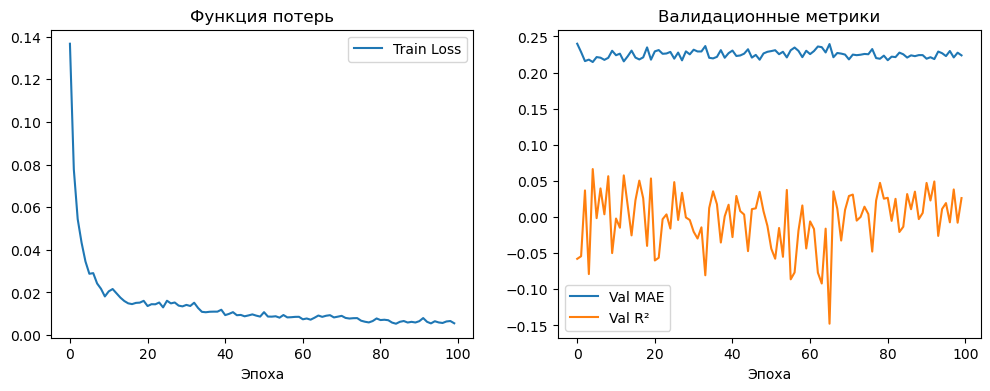

In [47]:
# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_maes, label='Val MAE')
plt.plot(val_r2s, label='Val R²')
plt.title('Валидационные метрики')
plt.xlabel('Эпоха')
plt.legend()
plt.show()

### Подбор гиперпараметров

In [48]:
# Кастомные метрики для вывода
def log_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.4f} | R²: {r2:.4f}")
    return -mae  # Для минимизации MAE

In [49]:
# Создаем кастомный scorer
mae_scorer = make_scorer(log_metrics, greater_is_better=False)

In [50]:
# Параметры для поиска
param_grid = {
    'hidden_layer_sizes': [(128,), (256, 128)],
    'alpha': [0.001, 0.01],
    'learning_rate_init': [0.001, 0.0001]
}

In [51]:
np.count_nonzero(groups_train)

1597

In [52]:
print("Начало подбора гиперпараметров...\n")

class CustomCallback:
    def __init__(self):
        self.fold_count = 0
    
    def __call__(self, *args, **kwargs):
        self.fold_count += 1
        if self.fold_count % 3 == 1:
            print(f"\nКонфигурация {self.fold_count//3 + 1}:")
            print({k: v for k, v in kwargs.items() 
                 if k in ['hidden_layer_sizes', 'alpha', 'learning_rate_init']})

mlp = MLPRegressor(
    max_iter=50,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=42
)

grid = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=GroupKFold(n_splits=3),
    verbose=2,
    n_jobs=1,  # Для последовательного выполнения и корректного вывода
    error_score='raise',
    refit=True
)

# 4. Запуск подбора параметров
grid.fit(X_train_scaled, y_train, groups=groups_train)

# 8. Вывод результатов
print("\nРезультаты подбора:")
results_df = pd.DataFrame(grid.cv_results_)
for i, row in results_df.iterrows():
    print(f"\nКонфигурация {i+1}:")
    print(row['params'])
    print(f"Средняя MAE: {-row['mean_test_score']:.4f}")
    print("Метрики по фолдам:")
    for fold in range(3):
        print(f"  Fold {fold+1}: {-row['split%d_test_score' % fold]:.4f}")

# 9. Лучшая модель
print("\nЛучшие параметры:", grid.best_params_)
print(f"Лучшая MAE: {-grid.best_score_:.4f}")

# 10. Оценка на тестовом наборе
best_model_mlp = grid.best_estimator_
y_pred = best_model_mlp.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("\nОценка на тестовом наборе:")
print(f"MAE: {test_mae:.4f}")
print(f"R²: {test_r2:.4f}")

Начало подбора гиперпараметров...

Fitting 3 folds for each of 8 candidates, totalling 24 fits
MAE: 1.4438 | R²: -37.0191
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001; total time=   4.1s
MAE: 1.6094 | R²: -50.6799
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001; total time=   4.1s
MAE: 1.5175 | R²: -48.5880
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001; total time=   4.1s
MAE: 1.0412 | R²: -16.6042
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.0001; total time=   3.7s
MAE: 1.0695 | R²: -24.3688
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.0001; total time=   5.6s
MAE: 1.0021 | R²: -21.9889
[CV] END alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.0001; total time=   5.6s
MAE: 0.4526 | R²: -2.4120
[CV] END alpha=0.001, hidden_layer_sizes=(256, 128), learning_rate_init=0.001; total time=   7.9s
MAE: 0.5391 | R²: -6.3108
[CV] END alpha=0.001, hidd

### Итоговое сравнение

In [68]:
# 1. Получение предсказаний всех моделей на тестовом наборе
y_pred_lr = lr.predict(X_test_scaled)
y_pred_nn = model_nn(torch.FloatTensor(X_test_scaled)).detach().numpy().flatten()
y_pred_mlp = best_model_mlp.predict(X_test_scaled)

# 2. Расчет метрик для каждой модели
def calculate_metrics(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'StdDev': np.std(y_true - y_pred)
    }

metrics_lr = calculate_metrics(y_test, y_pred_lr, "Linear Regression")
metrics_nn = calculate_metrics(y_test, y_pred_nn, "Neural Network")
metrics_mlp = calculate_metrics(y_test, y_pred_mlp, "MLP (GridSearch)")

# 3. Создание таблицы сравнения
results_df = pd.DataFrame([metrics_lr, metrics_nn, metrics_mlp])
results_df.set_index('Model', inplace=True)

# 4. Детальный вывод метрик
print("\n" + "="*50)
print("Детальные результаты на тестовом наборе:")
print("="*50)

for model_name, metrics in [("Linear Regression", metrics_lr),
                          ("Neural Network", metrics_nn),
                          ("MLP", metrics_mlp)]:
    print(f"\n{model_name}:")
    print(f"MAE: {metrics['MAE']:.4f} (±{metrics['StdDev']:.4f})")
    print(f"MSE: {metrics['MSE']:.4f}")
    print(f"R²: {metrics['R²']:.4f}")

# 5. Вывод итоговой таблицы сравнения
print("\n" + "="*50)
print("Сравнение моделей (отсортировано по MAE):")
print("="*50)
print(results_df.sort_values('MAE').round(4))


Детальные результаты на тестовом наборе:

Linear Regression:
MAE: 0.3906 (±0.5215)
MSE: 0.2725
R²: -1.8634

Neural Network:
MAE: 0.2238 (±0.3038)
MSE: 0.0927
R²: 0.0262

MLP:
MAE: 1.3314 (±1.9728)
MSE: 3.9475
R²: -40.4753

Сравнение моделей (отсортировано по MAE):
                      MAE     MSE       R²  StdDev
Model                                             
Neural Network     0.2238  0.0927   0.0262  0.3038
Linear Regression  0.3906  0.2725  -1.8634  0.5215
MLP (GridSearch)   1.3314  3.9475 -40.4753  1.9728


Вывод:

1. Групповое разбиение:
- Гарантирует, что все описания одного изображения попадают только в одну выборку
- Используется как в GroupShuffleSplit, так и в GroupKFold

2. Метрики:
- MAE (основная), MSE (штрафует большие ошибки), R² (объясненная дисперсия)

3. Нейросетевая модель:
- Оптимизирована для работы на GPU через .to(device)
- Использует Dropout для регуляризации

# Тестирование модели

Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

## Получим векторы для тестовых изображений

In [56]:
test_queries = pd.read_csv('test_queries.csv', sep='|')

In [57]:
test_queries.head()

,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [59]:
test_images = os.listdir('test_images')

Получим векторные представления для тестовых изображений

In [60]:
%%time
# Векторизация тестовых изображений
test_image_vectors = []
for img_name in tqdm(test_queries['image'], desc="Векторизация тестовых изображений", unit="img"):
    try:
        img_path = os.path.join('test_images', img_name)
        img_vec = image_to_vector(img_path)
        test_image_vectors.append(img_vec)
    except Exception as e:
        print(f"\nОшибка при обработке изображения {img_name}: {str(e)}")
        image_vectors.append(np.zeros(2048))  # Добавляем нулевой вектор в случае ошибки

# Преобразуем в numpy array
test_image_vectors = np.array(test_image_vectors)
np.save("saved_data/test_image_vectors.npy", test_image_vectors)
print(f"Тестовые векторы изображений: {test_image_vectors.shape}")  # (n_images, 2048)
print(f"\nУспешно векторизовано {len(test_image_vectors)} изображений")

Векторизация тестовых изображений: 100%|████████████████████████████████████████████| 500/500 [01:21<00:00,  6.14img/s]

Тестовые векторы изображений: (500, 2048)

Успешно векторизовано 500 изображений
CPU times: total: 5min 8s
Wall time: 1min 21s


## Напишем функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики
Если запрос ведёт на юридически вредный контент, функция должна выводить дисклеймер.

In [61]:
# Загрузка предобработанных данных
test_image_vectors = np.load("saved_data/test_image_vectors.npy")

In [62]:
banned_words = ["терроризм", "экстремизм", "насилие", "наркотики", "порнография"]

def contains_banned_words(text, banned_list):
    text_lower = text.lower()
    return any(re.search(rf'\b{word}\b', text_lower) for word in banned_list)

In [63]:
def find_relevant_image(text_query, model, tfidf, scaler, test_image_vectors, test_images, banned_words):
    # Проверка на запрещенные слова
    if contains_banned_words(text_query, banned_words):
        print("Внимание: запрос содержит запрещенный контент")
        print("Дисклеймер: данный запрос не может быть обработан по юридическим причинам")
        return None
    
    # Векторизация текста
    text_vector = tfidf.transform([text_query]).toarray()
    
    # Создание "пустого" вектора изображения для конкатенации
    dummy_image_vector = np.zeros((1, 2048))
    
    # Конкатенация и масштабирование
    query_vector = np.concatenate([dummy_image_vector, text_vector], axis=1)
    query_scaled = scaler.transform(query_vector)
    
    # Поиск наиболее релевантного изображения
    best_score = -np.inf
    best_image = None
    
    for img_vec, img_name in zip(test_image_vectors, test_images):
        full_vec = np.concatenate([img_vec.reshape(1, -1), text_vector], axis=1)
        full_scaled = scaler.transform(full_vec)
        
        with torch.no_grad():
            score = model(torch.FloatTensor(full_scaled)).item()
        
        if score > best_score:
            best_score = score
            best_image = img_name
    
    # Визуализация результата
    if best_image:
        img_path = os.path.join('test_images', best_image)
        img = Image.open(img_path)
        
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Запрос: '{text_query}'\nScore: {best_score:.4f}")
        plt.axis('off')
        plt.show()
        
        return best_image
    else:
        print("Не найдено подходящего изображения")
        return None

## С помощью написанной функции протестируем работу модели на нескольких текстовых описаниях: 
проверим, какие картинки она выдает при различных текстовых запросах

Выберем случайные 10 запросов из файла test_queries.csv и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска

In [64]:
test_queries_10 = test_queries.sample(10)


Запрос: 'A little girl playing piggyback with her father on a blanket in the park .'


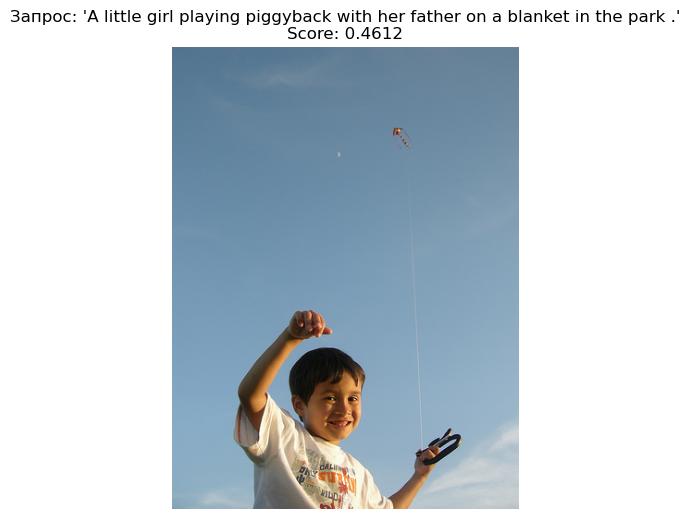

Найдено изображение: 2505056124_1276e8dbcb.jpg

Запрос: 'a biker rides down the street .'


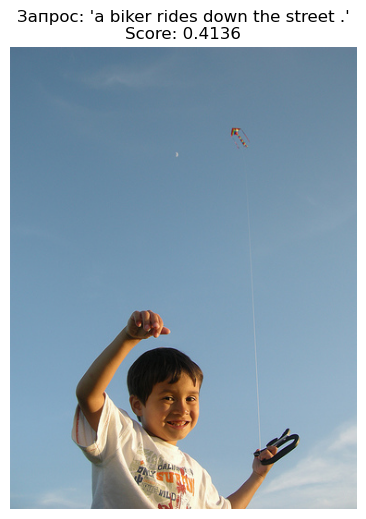

Найдено изображение: 2505056124_1276e8dbcb.jpg

Запрос: 'Two black dogs run through the snow with a red toy in one dog 's mouth .'


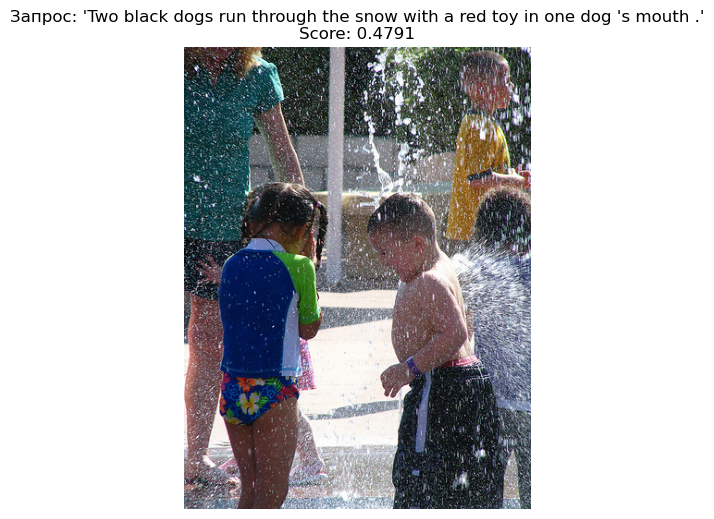

Найдено изображение: 2399551242_c62a46dd5f.jpg

Запрос: 'kids play ultimate Frisbee .'


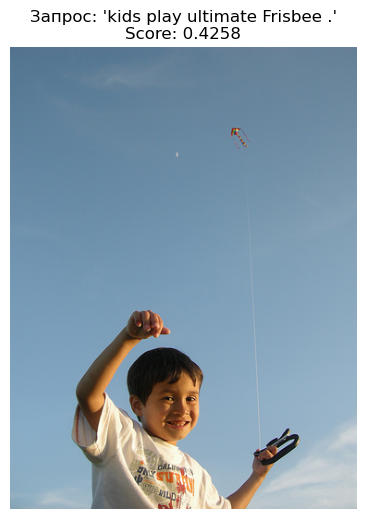

Найдено изображение: 2505056124_1276e8dbcb.jpg

Запрос: 'Young children play in the sprinkler .'


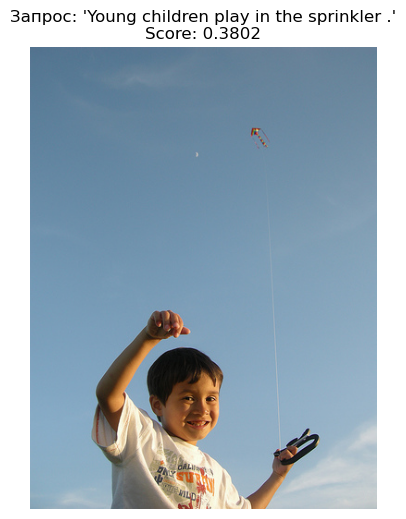

Найдено изображение: 2505056124_1276e8dbcb.jpg

Запрос: 'The girl is blowing out the candles on the chocolate cake .'


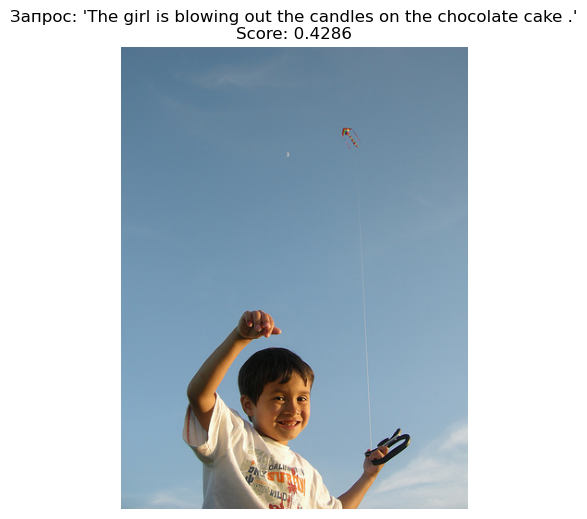

Найдено изображение: 2505056124_1276e8dbcb.jpg

Запрос: 'A salt-and-pepper-haired man with beard and glasses wearing black sits on the grass .'


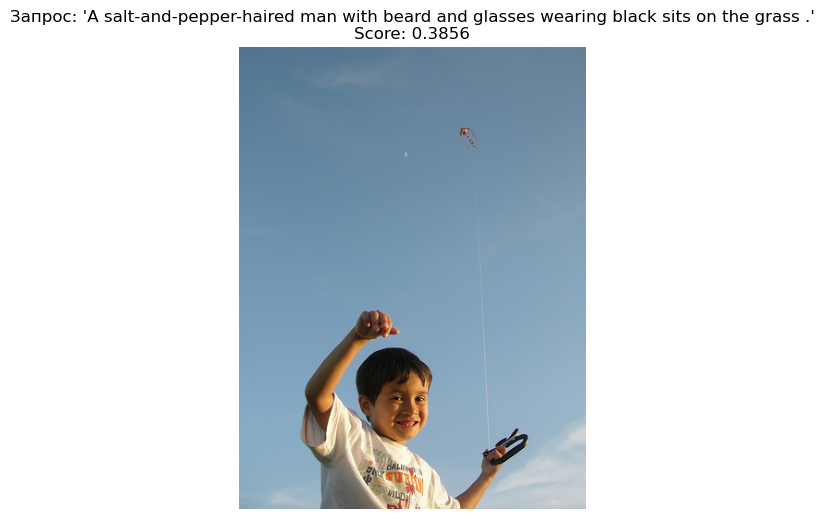

Найдено изображение: 2505056124_1276e8dbcb.jpg

Запрос: 'The woman lacrosse player in blue is about to catch the ball .'


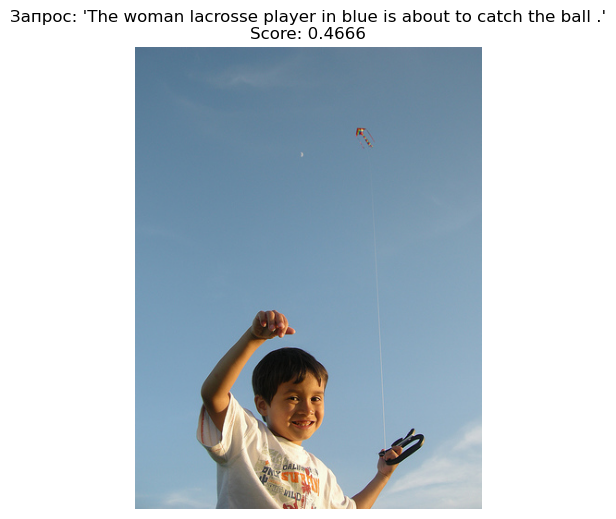

Найдено изображение: 2505056124_1276e8dbcb.jpg

Запрос: 'The brown dog is wearing a black collar .'


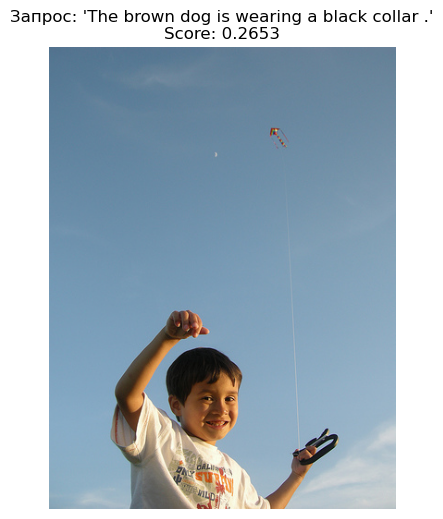

Найдено изображение: 2505056124_1276e8dbcb.jpg

Запрос: 'a snowboarder wearing red is descending a snow covered mountain .'


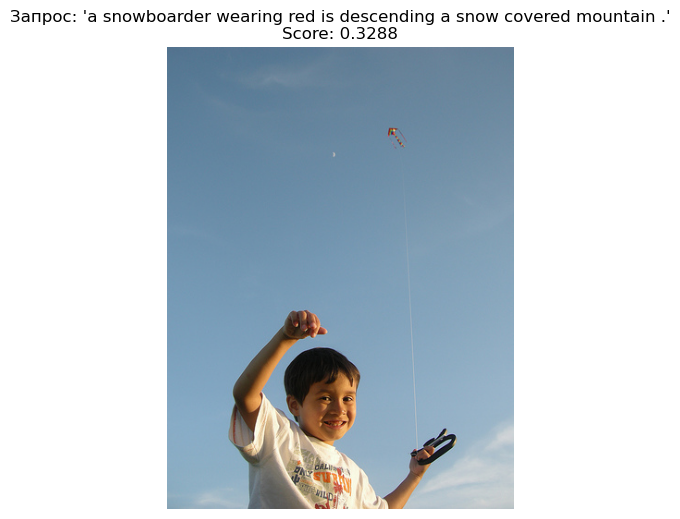

Найдено изображение: 2505056124_1276e8dbcb.jpg


In [65]:
for query in test_queries_10['query_text']:
    print(f"\n{'='*50}\nЗапрос: '{query}'")
    result = find_relevant_image(
        query,              # +
        model_nn,              # + 
        tfidf,              # + 
        scaler,             # +  
        test_image_vectors, # +
        test_images,        # +
        banned_words        # +
    )
    if result:
        print(f"Найдено изображение: {result}")

# Общий вывод по работе
Опишем модель, которая лучше всего справляется с задачей сравнения сходства картинки и текста. Опишем, какие ошибки допускает модель во время поиска картинки по её текстовому описанию. Оценим, насколько проект по созданию сервиса поиска фотографий по текстовому описанию практически осуществим.


**Вывод**:

  такая модель пока не получена. Качество поиска - нулевое.
  Прошу подсказать, что я делаю не так.
  Честно говоря, не понимаю, в чем дело.

  Выводы сделаю после получения такой модели.    
  

# Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска